In [6]:
import os
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from PIL import ImageFile


ImageFile.LOAD_TRUNCATED_IMAGES = True

torch.manual_seed(777)  # reproducibility

# parameters
total_dog_classes = 133
learning_rate = 0.001
batch_size = 10
keep_prob = 0.7
data_dir="./all_images/dogImages/"
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'


# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),    
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
                  VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
                  TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

image_datasets = {x: dsets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in [TRAIN, VAL, TEST]}



dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=0)
              for x in [TRAIN, VAL, TEST]}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}
class_names = image_datasets[TRAIN].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("number of training images:", len(image_datasets[TRAIN]))
print("numbe of validation images:", len(image_datasets[VAL]))
print("number of testing images:", len(image_datasets[TEST]))

number of training images: 6680
numbe of validation images: 835
number of testing images: 836


In [17]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask and place on input device
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).to(x)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)
    
class DropBlockScheduled(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(DropBlockScheduled, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start=start_value, stop=stop_value, num=int(nr_steps))

    def forward(self, x):
        if self.training:
            self.step()
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1

In [18]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def Conv_3x3(inp, oup, stride, activation=nn.ReLU6, act_params={"inplace": True}):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        activation(**act_params)
    )


def Conv_1x1(inp, oup, activation=nn.ReLU6, act_params={"inplace": True}):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        activation(**act_params)
    )


def SepConv_3x3(inp, oup, activation=nn.ReLU6, act_params={"inplace": True}):  # input=32, output=16
    return nn.Sequential(
        # dw
        nn.Conv2d(inp, inp, 3, 1, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        activation(**act_params),
        # pw-linear
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, kernel, drop_prob=0.0, num_steps=3e5, activation=nn.ReLU6,
                 act_params={"inplace": True}):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        self.use_res_connect = self.stride == 1 and inp == oup

        self.conv = nn.Sequential(
            # pw
            nn.Conv2d(inp, inp * expand_ratio, 1, 1, 0, bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            DropBlockScheduled(
                DropBlock2D(drop_prob=drop_prob, block_size=7),
                start_value=0.,
                stop_value=drop_prob,
                nr_steps=num_steps),
            activation(**act_params),
            # dw
            nn.Conv2d(inp * expand_ratio, inp * expand_ratio, kernel, stride, kernel // 2, groups=inp * expand_ratio,
                      bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            DropBlockScheduled(
                DropBlock2D(drop_prob=drop_prob, block_size=7),
                start_value=0.,
                stop_value=drop_prob,
                nr_steps=num_steps),
            activation(**act_params),
            # pw-linear
            nn.Conv2d(inp * expand_ratio, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
            DropBlockScheduled(
                DropBlock2D(drop_prob=drop_prob, block_size=7),
                start_value=0.,
                stop_value=drop_prob,
                nr_steps=num_steps),
        )
        if self.use_res_connect:
            self.skip_drop = DropBlockScheduled(
                DropBlock2D(drop_prob=drop_prob, block_size=7),
                start_value=0.,
                stop_value=drop_prob,
                nr_steps=num_steps)

    def forward(self, x):
        if self.use_res_connect:
            return self.skip_drop(x + self.conv(x))
        else:
            return self.conv(x)


class MnasNet(nn.Module):
    def __init__(self, n_class=total_dog_classes, input_size=224, width_mult=1., drop_prob=0.0, num_steps=3e5, activation=nn.ReLU6,
                 act_params={"inplace": True}):
        super(MnasNet, self).__init__()

        self.activation = activation
        self.act_params = act_params

        # setting of inverted residual blocks
        self.interverted_residual_setting = [
            # t, c, n, s, k, dp
            [3, 24, 3, 2, 3, 0],  # -> 56x56
            [3, 40, 3, 2, 5, 0],  # -> 28x28
            [6, 80, 3, 2, 5, 0],  # -> 14x14
            [6, 96, 2, 1, 3, drop_prob],  # -> 14x14
            [6, 192, 4, 2, 5, drop_prob],  # -> 7x7
            [6, 320, 1, 1, 3, drop_prob],  # -> 7x7
        ]
        self.num_steps = num_steps

        assert input_size % 32 == 0
        input_channel = int(32 * width_mult)
        self.last_channel = int(1280 * width_mult) if width_mult > 1.0 else 1280

        # building first two layer
        self.features = [Conv_3x3(3, input_channel, 2, self.activation, self.act_params),
                         SepConv_3x3(input_channel, 16, self.activation, self.act_params)]
        input_channel = 16

        # building inverted residual blocks (MBConv)
        for t, c, n, s, k, dp in self.interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(InvertedResidual(input_channel, output_channel, s, t, k, dp, self.num_steps,
                                                          self.activation, self.act_params))
                else:
                    self.features.append(InvertedResidual(input_channel, output_channel, 1, t, k, dp, self.num_steps,
                                                          self.activation, self.act_params))
                input_channel = output_channel

        # building last several layers
        self.features.append(Conv_1x1(input_channel, self.last_channel, self.activation, self.act_params))
        self.features.append(nn.AdaptiveAvgPool2d(1))

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.0),  # TODO
            nn.Linear(self.last_channel, n_class),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.last_channel)
        x = self.classifier(x)
        return x
                
model_scratch = MnasNet()

print(model_scratch)

# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()
else:
    print("cuda is not available.")

MnasNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): DropBlockScheduled(
          (dropblock): DropBlock2D()
        )
        (3): R

In [19]:
import torch.optim as optim
from torch.optim import lr_scheduler
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_scratch, step_size = 7, gamma=0.1)

In [20]:
import matplotlib.pyplot as plt
from PIL import ImageFile
import numpy as np
import time
import copy

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm
import torch

batch_size = 10
train_data = image_datasets[TRAIN]
test_data = image_datasets[TEST]
# dataloaders
train_data_loader = dataloaders[TRAIN]
valid_data_loader = dataloaders[VAL]

# training function
def fit(model, dataloader, optimizer, criterion, train_data, device, use_amp):
    print('Training')
    if use_amp == 'yes':
        scaler = torch.cuda.amp.GradScaler() 
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, (image,target) in tqdm(enumerate(dataloader), total=int(len(train_data)/batch_size)):
        image, target = image.to(device), target.to(device)
        optimizer.zero_grad()
        
        if use_amp == 'yes':
            with torch.cuda.amp.autocast():
                outputs = model(image)
                loss = criterion(outputs, target)
        
        elif use_amp == 'no':
            outputs = model(image)
            loss = criterion(outputs, target)
            
        train_running_loss += (1/(i+1))*(loss.item() - train_running_loss)
        _, preds = torch.max(outputs, 1)
        train_running_correct += (preds == target).sum().item()
        
        if use_amp == 'yes':
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        elif use_amp == 'no':
            loss.backward()
            optimizer.step()
        
    train_loss = train_running_loss
    train_accuracy = 100. * train_running_correct/dataset_sizes[TRAIN]    
    return train_loss, train_accuracy

# validation function
def validate(model, dataloader, optimizer, criterion, val_data, device, use_amp):
    print('Validating')
    if use_amp == True:
        scaler = torch.cuda.amp.GradScaler() 
        
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, (image,target) in tqdm(enumerate(dataloader), total=int(len(val_data)/batch_size)):
            image, target = image.to(device), target.to(device)
            
            if use_amp == 'yes':
                with torch.cuda.amp.autocast():
                    outputs = model(image)
                    loss = criterion(outputs, target)
        
            elif use_amp == 'no':
                outputs = model(image)
                loss = criterion(outputs, target)
            
            val_running_loss += (1/(i+1))*(loss.item() - val_running_loss)
            _, preds = torch.max(outputs, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss
        val_accuracy = 100. * val_running_correct/dataset_sizes[VAL]        
        return val_loss, val_accuracy
    
def train(epochs, model, criterion, optimizer, scheduler):
    since = time.time()
     
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    use_amp = input("Do you want to use amp? (yes/no)")
    if use_amp == 'yes':
        print('Tranining and validating with Automatic Mixed Precision')
    else:
        print('Tranining and validating without Automatic Mixed Precision')
    
    start = time.time()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_accuracy = fit(model, train_data_loader, 
                                                     optimizer, criterion, 
                                                     train_data, device, use_amp)
        val_epoch_loss, val_epoch_accuracy = validate(model, valid_data_loader, 
                                                     optimizer, criterion, 
                                                     test_data, device, use_amp)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_accuracy)
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
    end = time.time()
    print(f"Took {((end-start)/60):.3f} minutes to train for {epochs} epochs")

    # save model checkpoint
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"./graphs/mnasnet_amp_{use_amp}_model.pt")
    
    return train_loss, val_loss, train_acc, val_acc, use_amp

Do you want to use amp? (yes/no)yes


  0%|          | 1/668 [00:00<01:27,  7.65it/s]

Tranining and validating with Automatic Mixed Precision
Epoch 1 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.16it/s]                        
  0%|          | 1/668 [00:00<01:35,  7.00it/s]

Train Loss: 4.8841, Train Acc: 1.15
Val Loss: 4.7825, Val Acc: 2.04
Epoch 2 of 100
Training


  1%|          | 1/83 [00:00<00:10,  8.00it/s]

Validating


84it [00:11,  7.24it/s]                        
  0%|          | 1/668 [00:00<01:36,  6.93it/s]

Train Loss: 4.7313, Train Acc: 2.31
Val Loss: 4.5977, Val Acc: 3.23
Epoch 3 of 100
Training


  1%|          | 1/83 [00:00<00:15,  5.20it/s]

Validating


84it [00:11,  7.18it/s]                        
  0%|          | 1/668 [00:00<01:52,  5.94it/s]

Train Loss: 4.5970, Train Acc: 3.01
Val Loss: 4.6495, Val Acc: 2.16
Epoch 4 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.32it/s]

Validating


84it [00:11,  7.21it/s]                        
  0%|          | 1/668 [00:00<01:32,  7.18it/s]

Train Loss: 4.4969, Train Acc: 3.26
Val Loss: 4.3467, Val Acc: 4.43
Epoch 5 of 100
Training


  1%|          | 1/83 [00:00<00:10,  8.12it/s]

Validating


84it [00:11,  7.25it/s]                        
  0%|          | 1/668 [00:00<01:56,  5.71it/s]

Train Loss: 4.4248, Train Acc: 4.64
Val Loss: 4.3000, Val Acc: 4.43
Epoch 6 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.15it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 4.3459, Train Acc: 5.03
Val Loss: 4.1008, Val Acc: 6.83
Epoch 7 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.10it/s]

Validating


84it [00:11,  7.22it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 4.2749, Train Acc: 5.72
Val Loss: 4.0191, Val Acc: 8.38
Epoch 8 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.16it/s]                        
  0%|          | 1/668 [00:00<01:57,  5.69it/s]

Train Loss: 4.1983, Train Acc: 6.50
Val Loss: 3.9629, Val Acc: 8.50
Epoch 9 of 100
Training


  1%|          | 1/83 [00:00<00:09,  9.04it/s]

Validating


84it [00:11,  7.19it/s]                        
  0%|          | 1/668 [00:00<01:52,  5.94it/s]

Train Loss: 4.1605, Train Acc: 6.84
Val Loss: 3.8126, Val Acc: 10.90
Epoch 10 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.61it/s]

Validating


84it [00:11,  7.29it/s]                        
  0%|          | 1/668 [00:00<01:31,  7.30it/s]

Train Loss: 4.0512, Train Acc: 7.98
Val Loss: 3.7724, Val Acc: 12.81
Epoch 11 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.16it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.9809, Train Acc: 8.80
Val Loss: 3.6450, Val Acc: 12.46
Epoch 12 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.15it/s]                        
  0%|          | 1/668 [00:00<01:42,  6.51it/s]

Train Loss: 3.9429, Train Acc: 9.67
Val Loss: 3.6314, Val Acc: 13.53
Epoch 13 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.46it/s]

Validating


84it [00:11,  7.19it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.8613, Train Acc: 10.42
Val Loss: 3.4616, Val Acc: 15.81
Epoch 14 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.82it/s]

Validating


84it [00:11,  7.24it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.8308, Train Acc: 11.68
Val Loss: 3.4998, Val Acc: 15.45
Epoch 15 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.64it/s]

Validating


84it [00:11,  7.22it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.7010, Train Acc: 13.13
Val Loss: 3.4297, Val Acc: 17.72
Epoch 16 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.54it/s]

Validating


84it [00:11,  7.24it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.6494, Train Acc: 13.49
Val Loss: 3.4202, Val Acc: 18.20
Epoch 17 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.25it/s]

Validating


84it [00:11,  7.19it/s]                        
  0%|          | 1/668 [00:00<01:49,  6.10it/s]

Train Loss: 3.5968, Train Acc: 14.61
Val Loss: 3.2228, Val Acc: 19.88
Epoch 18 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.26it/s]

Validating


84it [00:11,  7.22it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.4967, Train Acc: 16.44
Val Loss: 3.2128, Val Acc: 20.36
Epoch 19 of 100
Training


  1%|          | 1/83 [00:00<00:13,  5.96it/s]

Validating


84it [00:11,  7.24it/s]                        
  0%|          | 1/668 [00:00<01:42,  6.50it/s]

Train Loss: 3.4563, Train Acc: 16.83
Val Loss: 3.1523, Val Acc: 23.59
Epoch 20 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.22it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.3884, Train Acc: 18.47
Val Loss: 2.9758, Val Acc: 24.91
Epoch 21 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<01:55,  5.79it/s]

Train Loss: 3.3264, Train Acc: 19.31
Val Loss: 2.9762, Val Acc: 25.87
Epoch 22 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.21it/s]                        
  0%|          | 1/668 [00:00<01:36,  6.91it/s]

Train Loss: 3.2773, Train Acc: 19.96
Val Loss: 3.0809, Val Acc: 25.39
Epoch 23 of 100
Training


  1%|          | 1/83 [00:00<00:13,  5.96it/s]

Validating


84it [00:11,  7.21it/s]                        
  0%|          | 1/668 [00:00<02:07,  5.23it/s]

Train Loss: 3.2344, Train Acc: 20.76
Val Loss: 2.8252, Val Acc: 27.90
Epoch 24 of 100
Training


  1%|          | 1/83 [00:00<00:13,  6.13it/s]

Validating


84it [00:11,  7.17it/s]                        
  0%|          | 1/668 [00:00<01:54,  5.80it/s]

Train Loss: 3.1373, Train Acc: 23.43
Val Loss: 2.8187, Val Acc: 28.62
Epoch 25 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.80it/s]

Validating


84it [00:11,  7.13it/s]                        
  0%|          | 1/668 [00:00<01:46,  6.28it/s]

Train Loss: 3.1460, Train Acc: 22.59
Val Loss: 2.7153, Val Acc: 31.14
Epoch 26 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.58it/s]

Validating


84it [00:11,  7.24it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.0693, Train Acc: 24.39
Val Loss: 2.5490, Val Acc: 32.10
Epoch 27 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.56it/s]

Validating


84it [00:11,  7.13it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 3.0291, Train Acc: 24.12
Val Loss: 2.5433, Val Acc: 31.86
Epoch 28 of 100
Training


  1%|          | 1/83 [00:00<00:13,  6.00it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.9576, Train Acc: 26.39
Val Loss: 2.5889, Val Acc: 31.50
Epoch 29 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.98it/s]

Validating


84it [00:11,  7.18it/s]                        
  0%|          | 1/668 [00:00<02:04,  5.38it/s]

Train Loss: 2.9061, Train Acc: 27.75
Val Loss: 2.4311, Val Acc: 37.72
Epoch 30 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.17it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.8384, Train Acc: 29.24
Val Loss: 2.4524, Val Acc: 35.33
Epoch 31 of 100
Training


  1%|          | 1/83 [00:00<00:09,  9.09it/s]

Validating


84it [00:11,  7.23it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.7895, Train Acc: 30.13
Val Loss: 2.3042, Val Acc: 37.13
Epoch 32 of 100
Training


  1%|          | 1/83 [00:00<00:11,  6.90it/s]

Validating


84it [00:11,  7.22it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.7128, Train Acc: 31.27
Val Loss: 2.2995, Val Acc: 38.44
Epoch 33 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.77it/s]

Validating


84it [00:11,  7.18it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.6656, Train Acc: 32.11
Val Loss: 2.2022, Val Acc: 42.04
Epoch 34 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.17it/s]                        
  0%|          | 1/668 [00:00<01:32,  7.25it/s]

Train Loss: 2.6875, Train Acc: 31.99
Val Loss: 2.2778, Val Acc: 40.00
Epoch 35 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.24it/s]                        
  0%|          | 1/668 [00:00<02:11,  5.08it/s]

Train Loss: 2.6129, Train Acc: 33.40
Val Loss: 2.2441, Val Acc: 40.48
Epoch 36 of 100
Training


  1%|          | 1/83 [00:00<00:10,  8.15it/s]

Validating


84it [00:11,  7.17it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.5249, Train Acc: 35.19
Val Loss: 2.2282, Val Acc: 42.99
Epoch 37 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.25it/s]                        
  0%|          | 1/668 [00:00<01:42,  6.54it/s]

Train Loss: 2.4979, Train Acc: 36.06
Val Loss: 2.0844, Val Acc: 44.31
Epoch 38 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.35it/s]

Validating


84it [00:11,  7.49it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.4639, Train Acc: 36.39
Val Loss: 2.0001, Val Acc: 45.15
Epoch 39 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.76it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.4497, Train Acc: 37.01
Val Loss: 1.9116, Val Acc: 47.43
Epoch 40 of 100
Training


  2%|▏         | 2/83 [00:00<00:06, 11.71it/s]

Validating


84it [00:11,  7.53it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.4188, Train Acc: 37.29
Val Loss: 1.8229, Val Acc: 50.42
Epoch 41 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 11.56it/s]

Validating


84it [00:11,  7.49it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.3731, Train Acc: 38.56
Val Loss: 1.8333, Val Acc: 48.38
Epoch 42 of 100
Training


  1%|          | 1/83 [00:00<00:14,  5.61it/s]

Validating


84it [00:11,  7.41it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.3481, Train Acc: 39.31
Val Loss: 1.8709, Val Acc: 48.14
Epoch 43 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.41it/s]

Validating


84it [00:11,  7.42it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.2964, Train Acc: 40.52
Val Loss: 1.8144, Val Acc: 50.42
Epoch 44 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.51it/s]                        
  0%|          | 1/668 [00:00<02:11,  5.08it/s]

Train Loss: 2.2529, Train Acc: 41.23
Val Loss: 1.6784, Val Acc: 51.62
Epoch 45 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.44it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.2134, Train Acc: 42.29
Val Loss: 1.8208, Val Acc: 50.90
Epoch 46 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.47it/s]

Validating


84it [00:11,  7.52it/s]                        
  0%|          | 1/668 [00:00<02:09,  5.13it/s]

Train Loss: 2.2002, Train Acc: 42.74
Val Loss: 1.7444, Val Acc: 51.14
Epoch 47 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.34it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.1485, Train Acc: 43.19
Val Loss: 1.7361, Val Acc: 51.26
Epoch 48 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.43it/s]

Validating


84it [00:11,  7.46it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.1495, Train Acc: 43.46
Val Loss: 1.6768, Val Acc: 54.49
Epoch 49 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.85it/s]

Validating


84it [00:11,  7.46it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 2.1004, Train Acc: 44.93
Val Loss: 1.6730, Val Acc: 55.69
Epoch 50 of 100
Training


 53%|█████▎    | 352/668 [01:04<00:56,  5.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 1/668 [00:00<02:07,  5.23it/s]

Train Loss: 1.9231, Train Acc: 49.37
Val Loss: 1.4528, Val Acc: 59.28
Epoch 56 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.79it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 1/668 [00:00<02:09,  5.16it/s]

Train Loss: 1.9120, Train Acc: 49.97
Val Loss: 1.6306, Val Acc: 56.53
Epoch 57 of 100
Training


  1%|          | 1/83 [00:00<00:13,  5.98it/s]

Validating


84it [00:11,  7.42it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.8548, Train Acc: 50.93
Val Loss: 1.5211, Val Acc: 57.13
Epoch 58 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.62it/s]

Validating


84it [00:11,  7.41it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.8691, Train Acc: 50.57
Val Loss: 1.3791, Val Acc: 60.48
Epoch 59 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.8320, Train Acc: 52.46
Val Loss: 1.3808, Val Acc: 61.20
Epoch 60 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.61it/s]

Validating


84it [00:11,  7.47it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.8382, Train Acc: 51.69
Val Loss: 1.3759, Val Acc: 62.87
Epoch 61 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.83it/s]

Validating


84it [00:11,  7.59it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.7880, Train Acc: 52.71
Val Loss: 1.4026, Val Acc: 60.84
Epoch 62 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.32it/s]

Validating


84it [00:11,  7.57it/s]                        
  0%|          | 1/668 [00:00<02:05,  5.34it/s]

Train Loss: 1.7898, Train Acc: 52.98
Val Loss: 1.3825, Val Acc: 60.24
Epoch 63 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.46it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.7512, Train Acc: 54.39
Val Loss: 1.4288, Val Acc: 58.68
Epoch 64 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.93it/s]

Validating


84it [00:11,  7.58it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.7321, Train Acc: 53.17
Val Loss: 1.4032, Val Acc: 60.36
Epoch 65 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.74it/s]

Validating


84it [00:11,  7.56it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.7261, Train Acc: 53.86
Val Loss: 1.3617, Val Acc: 61.08
Epoch 66 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.44it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.7114, Train Acc: 54.91
Val Loss: 1.3483, Val Acc: 61.80
Epoch 67 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.81it/s]

Validating


84it [00:11,  7.48it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6915, Train Acc: 55.43
Val Loss: 1.2864, Val Acc: 64.19
Epoch 68 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.47it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6437, Train Acc: 56.42
Val Loss: 1.3554, Val Acc: 62.16
Epoch 69 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.53it/s]

Validating


84it [00:11,  7.39it/s]                        
  0%|          | 1/668 [00:00<02:09,  5.16it/s]

Train Loss: 1.7409, Train Acc: 54.01
Val Loss: 1.2960, Val Acc: 63.83
Epoch 70 of 100
Training


  1%|          | 1/83 [00:00<00:09,  9.10it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6485, Train Acc: 55.49
Val Loss: 1.2657, Val Acc: 63.47
Epoch 71 of 100
Training


  2%|▏         | 2/83 [00:00<00:06, 11.59it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.5804, Train Acc: 57.65
Val Loss: 1.3031, Val Acc: 62.75
Epoch 72 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 11.40it/s]

Validating


84it [00:11,  7.44it/s]                        
  0%|          | 1/668 [00:00<01:53,  5.86it/s]

Train Loss: 1.5838, Train Acc: 58.53
Val Loss: 1.3080, Val Acc: 62.51
Epoch 73 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.40it/s]

Validating


84it [00:11,  7.39it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.6269, Train Acc: 56.99
Val Loss: 1.2558, Val Acc: 63.71
Epoch 74 of 100
Training


  1%|          | 1/83 [00:00<00:09,  9.05it/s]

Validating


84it [00:11,  7.61it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.5710, Train Acc: 57.98
Val Loss: 1.2034, Val Acc: 65.63
Epoch 75 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.41it/s]

Validating


84it [00:11,  7.39it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.5572, Train Acc: 58.71
Val Loss: 1.2973, Val Acc: 63.71
Epoch 76 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.61it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 1/668 [00:00<02:05,  5.32it/s]

Train Loss: 1.5278, Train Acc: 59.46
Val Loss: 1.1757, Val Acc: 65.99
Epoch 77 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.44it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.5264, Train Acc: 60.24
Val Loss: 1.2858, Val Acc: 65.27
Epoch 78 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.59it/s]

Validating


84it [00:11,  7.44it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.5224, Train Acc: 59.09
Val Loss: 1.1861, Val Acc: 65.15
Epoch 79 of 100
Training


  1%|          | 1/83 [00:00<00:12,  6.77it/s]

Validating


84it [00:11,  7.43it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.4678, Train Acc: 60.75
Val Loss: 1.2193, Val Acc: 66.59
Epoch 80 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.25it/s]

Validating


84it [00:11,  7.54it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.4670, Train Acc: 60.43
Val Loss: 1.2787, Val Acc: 63.83
Epoch 81 of 100
Training


  2%|▏         | 2/83 [00:00<00:08, 10.11it/s]

Validating


84it [00:11,  7.48it/s]                        
  0%|          | 1/668 [00:00<02:09,  5.15it/s]

Train Loss: 1.4820, Train Acc: 59.63
Val Loss: 1.2442, Val Acc: 65.87
Epoch 82 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.24it/s]

Validating


84it [00:12,  6.78it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.4531, Train Acc: 61.65
Val Loss: 1.2619, Val Acc: 65.51
Epoch 83 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.46it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.4689, Train Acc: 60.85
Val Loss: 1.1771, Val Acc: 65.27
Epoch 84 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.05it/s]

Validating


84it [00:11,  7.42it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.4440, Train Acc: 61.81
Val Loss: 1.2343, Val Acc: 66.95
Epoch 85 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 11.01it/s]

Validating


84it [00:11,  7.44it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.4416, Train Acc: 61.39
Val Loss: 1.1494, Val Acc: 67.07
Epoch 86 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.95it/s]

Validating


84it [00:11,  7.41it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.4391, Train Acc: 61.50
Val Loss: 1.1989, Val Acc: 65.75
Epoch 87 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.77it/s]

Validating


84it [00:11,  7.51it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3834, Train Acc: 63.10
Val Loss: 1.1334, Val Acc: 66.95
Epoch 88 of 100
Training


  2%|▏         | 2/83 [00:00<00:06, 12.57it/s]

Validating


84it [00:11,  7.43it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3737, Train Acc: 63.44
Val Loss: 1.1475, Val Acc: 67.07
Epoch 89 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.71it/s]

Validating


84it [00:11,  7.41it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3506, Train Acc: 63.61
Val Loss: 1.1492, Val Acc: 67.19
Epoch 90 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.47it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3184, Train Acc: 64.04
Val Loss: 1.1915, Val Acc: 66.95
Epoch 91 of 100
Training


  1%|          | 1/83 [00:00<00:10,  8.02it/s]

Validating


84it [00:11,  7.54it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3318, Train Acc: 64.48
Val Loss: 1.1083, Val Acc: 68.86
Epoch 92 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3638, Train Acc: 64.13
Val Loss: 1.1159, Val Acc: 68.02
Epoch 93 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.41it/s]                        
  0%|          | 1/668 [00:00<02:04,  5.36it/s]

Train Loss: 1.3258, Train Acc: 64.33
Val Loss: 1.1490, Val Acc: 68.26
Epoch 94 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.72it/s]

Validating


84it [00:11,  7.42it/s]                        
  0%|          | 1/668 [00:00<02:11,  5.07it/s]

Train Loss: 1.2884, Train Acc: 65.45
Val Loss: 1.1696, Val Acc: 67.43
Epoch 95 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.77it/s]

Validating


84it [00:11,  7.54it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.3282, Train Acc: 64.46
Val Loss: 1.1763, Val Acc: 67.43
Epoch 96 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 1/668 [00:00<02:03,  5.42it/s]

Train Loss: 1.2752, Train Acc: 66.06
Val Loss: 1.1369, Val Acc: 67.90
Epoch 97 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2752, Train Acc: 65.88
Val Loss: 1.0673, Val Acc: 68.26
Epoch 98 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.62it/s]

Validating


84it [00:11,  7.43it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2837, Train Acc: 65.75
Val Loss: 1.1614, Val Acc: 66.71
Epoch 99 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.62it/s]

Validating


84it [00:11,  7.46it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Train Loss: 1.2668, Train Acc: 67.14
Val Loss: 1.0803, Val Acc: 69.94
Epoch 100 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.30it/s]

Validating


84it [00:11,  7.43it/s]                        


Train Loss: 1.2776, Train Acc: 65.43
Val Loss: 1.1459, Val Acc: 66.71
Took 237.375 minutes to train for 100 epochs


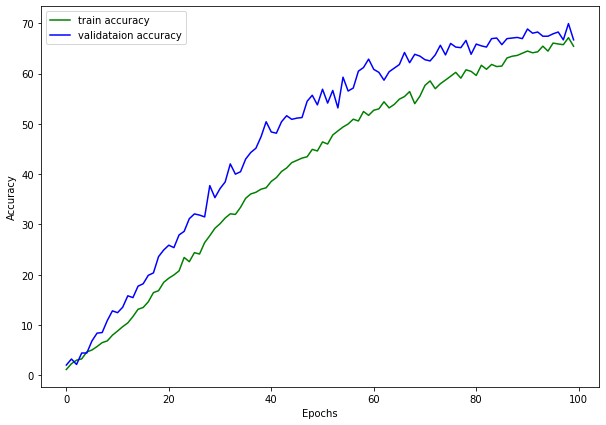

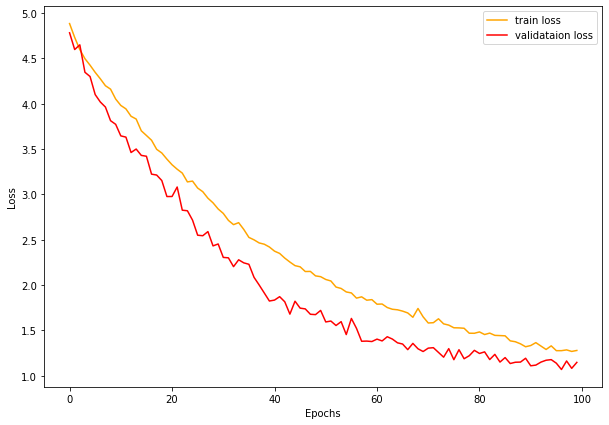

In [21]:
# train the model
train_loss, val_loss, train_acc, val_acc, use_amp = train(100, model_scratch, criterion_scratch, optimizer_scratch, exp_lr_scheduler)

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_acc, color='green', label='train accuracy')
plt.plot(val_acc, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"./graphs/mnasnet_amp_{use_amp}_accuracy.png")
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"./graphs/mnasnet_amp_{use_amp}_loss.png")
plt.show()

In [22]:
def test(model, criterion):
    since = time.time()
    # monitor test loss and accuracy
    print("Evaluating model")
    print("-" * 10)
    model.eval()
    
    test_loss = 0.
    test_acc = 0.
    correct = 0.
    total = 0.
    
    for i, data in enumerate(dataloaders[TEST]):
        images, target = data
        # move to GPU
        images, target = images.to(device), target.to(device)
                
        # forward pass: compute predicted outputs by passing inputs to the model
        with torch.no_grad():
            outputs = model(images)
            # calculate the loss
            _, preds = torch.max(outputs.data, 1)
            
            #pred = output.data.max(1, keepdim=True)[1]
            loss = criterion(outputs, target)
            # update average test loss  
            test_loss = test_loss + ((1 / (i + 1)) * (loss.item() - test_loss))
                       
            # compare predictions to true label
            total += target.size(0)
            correct += (preds == target).double().sum().item()
            
    avg_loss = test_loss
    elapsed_time = time.time() - since

    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("\nTest Loss: {:.6f}\n".format(avg_loss))
    print("\nTest Accuracy: {:.3f}% {:.0f}/{:.0f}".format(100. * correct / total, correct, total))
    print('-' * 10)

In [23]:
# call test function    
test(model_scratch, criterion_scratch)

Evaluating model
----------
Evaluation completed in 0m 12s

Test Loss: 1.143257


Test Accuracy: 69.856% 584/836
----------
